# Uniaxial Tension - Elasticity, Physics Informed Neural Network

Thomas Allard and Samantha Walker

In [41]:
#Imports
import os, sys, time
import numpy as np 
from sciann.utils.math import diff
from sciann import SciModel, Functional, Parameter
from sciann import Data, Tie
from sciann import Variable, Field
import matplotlib.pyplot as plt
import scipy.io
import netCDF4
import xarray as xr

import os
pi = np.pi

In [42]:
# Specify parameters and things
mode = 'train'   # 'test' to load PINN weights from previously trained model
                # 'train' to train a new model

current_file_name = 'elasticity_Yang3000_norm.ipynb'
    
#trained_file = 'trained-navier-stokes.hdf5'
data_file = '../abaqus/final_elastic/elastic_cdf.nc'

# file with nodal coordinates
node_file = '../abaqus/final_elastic/nodes.txt'

#layers = [40]*4
layers = [10, 40, 80, 100]
actf = 'tanh'
numx = 46
numy = 60
batchsize = 50
#batchsize = 16
epochs = 100
learningrate = 0.001
independent_networks = True
verbose = 2
shuffle = True
stopafter = 500
savefreq = 100000
dtype = 'float64'
gpu = False
outputpath = 'output_norm'
outputprefix = 'res'
numxplot = 46
numyplot = 60
plot = True


Emod = 210.0
nu = 0.3

E_range = [50, 300]
nu_range = [0.1, 0.4]
x_range = [0.0, 3000.0]
y_range = [-1500.0,1500.0]
disp_range = [-1.0, 1.0]
s_range = [0.0, 200.0]

In [43]:
# Functions
def dispx(input_d): # xx
    #x, y = xx[0], xx[1]
    disp_x = np.asarray(input_d.sel(field='ux'))
    disp_x = np.expand_dims(disp_x, axis=0).T
    return disp_x #np.cos(2*pi*x) * np.sin(pi*y)

def dispy(input_d): # xx
    #x, y = xx[0], xx[1]
    #Q = qload
    disp_y= np.asarray(input_d.sel(field='uy'))
    disp_y = np.expand_dims(disp_y, axis=0).T
    return disp_y #np.sin(pi*x) * Q * y**4/4

def stressxx(input_d): # xx
    stress_xx = np.asarray(input_d.sel(field='S11'))
    stress_xx = np.expand_dims(stress_xx, axis=0).T
    return stress_xx
    #set.sel(field='S11').to_array() #(lmbd+2*mu)*strainxx(xx) + lmbd*strainyy(xx)

def stressyy(input_d): # xx
    stress_yy = np.asarray(input_d.sel(field='S22'))
    stress_yy = np.expand_dims(stress_yy, axis=0).T
    return stress_yy
    #return set.sel(field='S22').to_array() #(lmbd+2*mu)*strainyy(xx) + lmbd*strainxx(xx)

def stressxy(input_d): # xx
    stress_xy = np.asarray(input_d.sel(field='S12'))
    stress_xy = np.expand_dims(stress_xy, axis=0).T
    return stress_xy
    #return set.sel(field='S21').to_array() #2.0*mu*strainxy(xx)

def cust_pcolor(AX, X, Y, C, title):
    im = AX.pcolor(X, Y, C, cmap="jet")
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    plt.colorbar(im, ax=AX)

def cust_semilogx(AX, X, Y, xlabel, ylabel):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)

# Create function to read text files in as np array
def file2array(file):
    # load in each line of data as array
    with open(file, 'r') as f:
        line_string = f.read().splitlines()
    
    # loop through the lines from the file, split, and append to list
    list = []
    timestamp = 0 # default 
    for i, line in enumerate(line_string):
        list.append(line.split())

    # convert list to an array of type float64
    array = np.asarray(list, dtype=np.float64)

    return(array)

def rearrange(numx, numy, field):
    stuff = np.zeros([numx,numy])
    for k,f in enumerate(field):
        i = int(k % numx)
        j = int(np.floor(k/numx))
        stuff[i,j] = f
        
    stuff = stuff.T
    return(stuff)

def normalize(value, min, max,a,b):
    norm = (b-a)*((value-min)/(max-min))+a
    return(norm)

def eval_mu_sig(X):
    return(X.mean(), X.std())

def std_normalize(X, mu, sig):
    return((X-mu)/sig)

def denormalize(X, mu, sig):
    return(X*sig + mu)

In [44]:
# load in data_file as xarray DataSet
set_in = xr.open_dataset(data_file)

In [45]:
# Load in displacements and create an ndarray
disp_x=set_in.sel(field='ux').to_array()
disp_y=set_in.sel(field='uy').to_array()
disps=np.dstack([disp_x,disp_y])

In [46]:
# Extract time and put in an array
times = [] # will be shape (81,)
for DataArray in set_in.values():
    times.append(DataArray.attrs['time'])
print(np.shape(times))

(81,)


In [47]:
# read in node file and save as grid
nodal_coordinates = file2array(node_file)
grid = nodal_coordinates[:,1:3]
#grid = np.array([grid[:,0],grid[:,1]+1500.])
grid = np.array([grid[:,0],grid[:,1]])
grid = np.expand_dims(grid, axis=0)
grid = np.moveaxis(grid, 0, -1)
print(np.shape(grid))
#print(grid)

(2, 2760, 1)


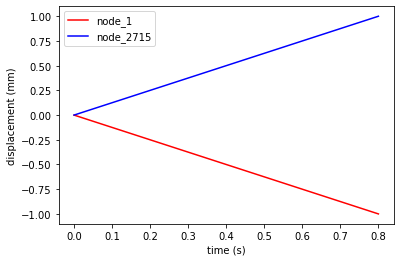

In [48]:
# Check that data loaded in correctly by plotting disp_y for node 1 (bottom left) and node 2715 (top left)
plt.plot(times,set_in.sel(field='uy',node='1').to_array(),   color='red',label='node_1')
plt.plot(times,set_in.sel(field='uy',node='2715').to_array(),color='blue',label='node_2715')
plt.xlabel('time (s)')
plt.ylabel('displacement (mm)')
plt.legend()
plt.show()

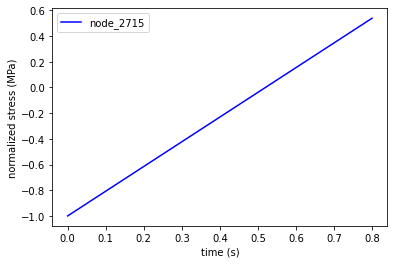

In [49]:
# Check that stress normalization is working
stresses=normalize(set_in.sel(field='S22',node='1').to_array(),s_range[0],s_range[1],-1,1)
plt.plot(times,stresses,color='blue',label='node_2715')
plt.xlabel('time (s)')
plt.ylabel('normalized stress (MPa)')
plt.legend()
plt.show()

In [50]:
# define function for subsampling data
def PrepareData(set_in, nodal_coordinates, times, random=True): # num_data, data_file
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    #data = scipy.io.loadmat(data_file)
    
    # will want to change these to correspond to our input variables
    #U_star = data['U_star'] # N x 2 x T
    ## displacements -> U_star
    #disp_x=normalize(set_in.sel(field='ux').to_array(),disp_range[0],disp_range[1],-1,1) # T x N # (81, 2760)
    #disp_y=normalize(set_in.sel(field='uy').to_array(),disp_range[0],disp_range[1],-1,1) # T x N # (81, 2760)
    disp_x=np.array(set_in.sel(field='ux').to_array()) # T x N # (81, 2760)
    disp_y=np.array(set_in.sel(field='uy').to_array()) # T x N # (81, 2760)
    u_mu, u_sig = eval_mu_sig(disp_x)
    v_mu, v_sig = eval_mu_sig(disp_y)
    dispx = std_normalize(disp_x, u_mu, u_sig)
    dispy = std_normalize(disp_y, v_mu, v_sig)
    U_star=np.dstack([dispx,dispy])     # T x N x 2 (81, 2760, 2)
    
    # time
    times = [] # will be shape (81,)
    for DataArray in set_in.values():
        times.append(DataArray.attrs['time'])
        
    
    # Solution S22 -> P_star
    sxx_star = normalize(np.asarray(set_in.sel(field='S11').to_array()),s_range[0],s_range[1],0,1) # T x N
    syy_star = normalize(np.asarray(set_in.sel(field='S22').to_array()),s_range[0],s_range[1],0,1) # T x N
    sxy_star = normalize(np.asarray(set_in.sel(field='S12').to_array()),s_range[0],s_range[1],0,1) # T x N

    # time -> t_star
    t_star = times #data['t'] # T x 1 # (81,)
    
    # grid -> X_star
    gridd = nodal_coordinates[:,1:3]
    #print(np.shape(gridd))
    #gridd = np.array([gridd[:,0],gridd[:,1]+1500.]).T
    #gridd = np.array([normalize(,x_range[0],x_range[1],-1,1),normalize(,y_range[0],y_range[1],-1,1)]).T
    #print(np.shape(gridd))
    grid_x = gridd[:,0]
    grid_y = gridd[:,1]
    x_mu, x_sig = eval_mu_sig(grid_x)
    y_mu, y_sig = eval_mu_sig(grid_y)
    gridx = std_normalize(grid_x, x_mu, x_sig).T
    gridy = std_normalize(grid_y, y_mu, y_sig).T
    gridd = np.array([gridx, gridy]).T
    #X_star = np.array([gridx, gridy]) # grid is N x 2 or shape (2760, 2)
    X_star = gridd
    
    N = np.shape(X_star)[0] #X_star.shape[0]
    T = np.shape(t_star)[0] #t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T # (2760, 81)
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T # (2760, 81)
    TT = np.tile(t_star, (1,N)).T # NT x 1 # (223560, 1)
    
    UU = U_star[:,:,0].T # N x T
    VV = U_star[:,:,1].T # N x T
    SSxx = sxx_star.T # N x T
    SSyy = syy_star.T # N x T
    SSxy = sxy_star.T # N x T

    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, N, replace=False) # num_data
    else:
        idx = np.arange(0, N*T)
    
    x = XX
    y = YY
    t = t_star
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
 
    
    u = UU # T x N # (81, 2760)
    v = VV # T x N # (81, 2760)
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    sxx = SSxx.flatten()[idx,None] # NT x 1
    syy = SSyy.flatten()[idx,None] # NT x 1
    sxy = SSxy.flatten()[idx,None] # NT x 1
    
        

    return (x,y,t,u,v,sxx,syy,sxy,[u_mu, v_mu, x_mu, y_mu], [u_sig, v_sig, x_sig, y_sig])


In [51]:
x,y,t,u,v,sxx, syy, sxy, mus, sigs = PrepareData(set_in, nodal_coordinates, times, random=True)

sig_mu, sig_sig = eval_mu_sig(syy)

# check shapes
print(f'shape of x = {np.shape(x)}')
print(f'shape of y = {np.shape(y)}')
print(f'shape of t = {np.shape(t)}')
print(f'shape of u = {np.shape(u)}')
print(f'shape of v = {np.shape(v)}')
print(f'shape of sxx = {np.shape(sxx)}')
print(f'shape of syy = {np.shape(syy)}')
print(f'shape of sxy = {np.shape(sxy)}')

shape of x = (2760, 1)
shape of y = (2760, 1)
shape of t = (2760, 1)
shape of u = (2760, 1)
shape of v = (2760, 1)
shape of sxx = (2760, 1)
shape of syy = (2760, 1)
shape of sxy = (2760, 1)


In [52]:
def plot(Emod, nu):
    output_file_name = os.path.join(outputpath, outputprefix)
    #fname = output_file_name + "_{}_".format(actf) + "x".join([str(x) for x in layers])
    fname = output_file_name + "_{}_".format(actf)
    
    loss = np.loadtxt(fname+"_loss")
    times = np.loadtxt(fname+"_Time")
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
    cust_semilogx(ax[0], None, loss/loss[0], "epochs", "L/L0")
    cust_semilogx(ax[1], times, loss/loss[0], "time(s)", None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_loss.png".format(output_file_name))
    
    Xmesh = np.loadtxt(fname+"_Xmesh", delimiter=',')
    Ymesh = np.loadtxt(fname+"_Ymesh", delimiter=',')
    
    input_d = set_in.step_080
    data_d1 = normalize(np.asarray(input_d.sel(field='ux')),disp_range[0],disp_range[1],-1,1)
    data_d2 = normalize(np.asarray(input_d.sel(field='uy')),disp_range[0],disp_range[1],-1,1)
    data_d3 = normalize(np.asarray(input_d.sel(field='S11')),s_range[0],s_range[1],-1,1)
    data_d4 = normalize(np.asarray(input_d.sel(field='S22')),s_range[0],s_range[1],-1,1)
    data_d5 = normalize(np.asarray(input_d.sel(field='S12')),s_range[0],s_range[1],-1,1)
    
    #Emods = normalize(Emod,E_range[0],E_range[1],0.1,1)
    #nus = normalize(nu,nu_range[0],nu_range[1],0.1,1)
    Emods = Emod
    nus = nu
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*Emods, "E*={:.3f}".format(Emods))
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*nu, "nu*={:.3f}".format(nus))
    Emods_pred = np.loadtxt(fname+"_Emods", delimiter=',')
    nus_pred = np.loadtxt(fname+"_nus", delimiter=',')
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.ones_like(Xmesh)*Emods_pred, "E={:.3f}".format(Emods_pred.mean()))
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.ones_like(Xmesh)*nus_pred, "nu={:.3f}".format(nus_pred.mean()))
    plt.savefig("{}_Parameters.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    plot_ux = rearrange(numx, numy, np.asarray(input_d.sel(field='ux')))
    plot_uy = rearrange(numx, numy, np.asarray(input_d.sel(field='uy')))
    print(np.shape(np.loadtxt(fname+"_U", delimiter=',')))
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_ux, "Ux*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_uy, "Uy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_U", delimiter=','), "Ux")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_V", delimiter=','), "Uy")
    plt.savefig("{}_Displacement.png".format(output_file_name))
    
    fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    #plot_s11 = rearrange(numx, numy, np.asarray(input_d.sel(field='S11')))
    plot_s22 = rearrange(numx, numy, normalize(np.asarray(input_d.sel(field='S22')),s_range[0],s_range[1],-1,1))
    #plot_s12 = rearrange(numx, numy, np.asarray(input_d.sel(field='S12')))
    plot_s11 = np.zeros([numy,numx])
    #plot_s22 = np.zeros([numx*numy,1])
    plot_s12 = np.zeros([numy,numx])
    cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_s11, "Sxx*")
    cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_s22, "Syy*")
    cust_pcolor(ax[0, 2], Xmesh, Ymesh, plot_s12, "Sxy*")
    cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Sxx", delimiter=','), "Sxx")
    cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Syy", delimiter=','), "Syy")
    cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Sxy", delimiter=','), "Sxy")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig("{}_Stress.png".format(output_file_name))
    
    #fig, ax = plt.subplots(2, 3, figsize=(11, 6), dpi=300)
    #plot_exx = rearrange(numx, numy, np.asarray(input_d.sel(field='NE11')))
    #plot_eyy = rearrange(numx, numy, np.asarray(input_d.sel(field='NE22')))
    #plot_exy = rearrange(numx, numy, np.asarray(input_d.sel(field='NE12')))
    #cust_pcolor(ax[0, 0], Xmesh, Ymesh, plot_exx, "Exx*")
    #cust_pcolor(ax[0, 1], Xmesh, Ymesh, plot_eyy, "Eyy*")
    #cust_pcolor(ax[0, 2], Xmesh, Ymesh, plot_exy, "Exy*")
    #cust_pcolor(ax[1, 0], Xmesh, Ymesh, np.loadtxt(fname+"_Exx", delimiter=','), "Exx")
    #cust_pcolor(ax[1, 1], Xmesh, Ymesh, np.loadtxt(fname+"_Eyy", delimiter=','), "Eyy")
    #cust_pcolor(ax[1, 2], Xmesh, Ymesh, np.loadtxt(fname+"_Exy", delimiter=','), "Exy")
    #fig.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.9, wspace=0.3, hspace=0.2)
    #plt.savefig("{}_Strain.png".format(output_file_name))

In [53]:
# Setting up cost function
#layers = 6
#neurons = 10

x = Variable("x", dtype='float64')
y = Variable("y", dtype='float64')
t = Variable("t", dtype='float64')

U = Functional("U", [x,y,t], layers, actf)
V = Functional("V", [x,y,t], layers, actf)
Sxx = Functional("Sxx", [x,y,t], layers, actf)
Syy = Functional("Syy", [x,y,t], layers, actf)
Sxy = Functional("Sxy", [x,y,t], layers, actf)

'''
Abaqus takes E and nu
The Navier form of equations takes mu and lambda

E = [mu*(3*lambda + 2*mu)] / [lambda + mu]
nu = lambda / [2*(lambda + mu)]

mu = E / [2*(1 + nu)]
lambda = [nu*E] / [(1 + nu)*(1 - 2*nu)]

Inputs values:
E  = 210 GPa -> 0.280
nu = 0.3     -> 0.333

Expected values:
mu     =  80.769231 GPa
lambda = 121.15438 GPa
'''

#Emods = Parameter(0.9*np.random.rand()+0.1, inputs=[x,y,t], min_max=[0.1,1.0], name="Emods")
#nus = Parameter(0.3*np.random.rand()+0.1, inputs=[x,y,t], min_max=[0.1,0.4], name="nus")
Emods = Parameter(np.random.rand(), inputs=[x,y,t], name="Emods")*Emod
nus = Parameter(np.random.rand(), inputs=[x,y,t], name="nus")*nu

# Call in training data
x_train, y_train, t_train, u_train, v_train, sxx_train, syy_train, sxy_train, mus, sigs = PrepareData(set_in, nodal_coordinates, times, random=True)
u_mu, u_sig = mus[0], sigs[0]
v_mu, v_sig = mus[1], sigs[1]
x_mu, x_sig = mus[2], sigs[2]
y_mu, y_sig = mus[3], sigs[3]
sig_sig = 100.


# Strains
Exx = diff(U, x)
Eyy = diff(V, y)
Exy = 0.5*(diff(U,y) + diff(V,x))

# define constraints
d1 = Data(U)
d2 = Data(V)
d3 = Data(Sxx)
d4 = Data(Syy)
d5 = Data(Sxy)

# some constants
C11 = Emods/(1-(nus**2))
C22 = C11*nus
C33 = Emods/(1*(1-nus))

# Equations
c1 = Tie(Sxx/sig_sig, (C11*Exx + C22*Eyy)/sig_sig)
c2 = Tie(Syy/sig_sig, (C11*Eyy + C22*Exx)/sig_sig)
c3 = Tie(Sxy/sig_sig, (C33*Exy)/sig_sig)

Lx = diff(Sxx, x) + diff(Sxy, y)
Ly = diff(Sxy, x) + diff(Syy, y)
d_Lx = Data(Lx/sig_sig)
d_Ly = Data(Ly/sig_sig)

if mode == 'train':
    
    # define output folder. 
    if not os.path.isdir(outputpath):
        os.mkdir(outputpath)
        
    output_file_name = os.path.join(outputpath, outputprefix)
    #fname = output_file_name + "_{}_".format(actf) + "x".join([str(x) for x in layers])
    fname = output_file_name + "_{}_".format(actf) 
    

    model = SciModel(
        inputs=[x, y, t],
        targets = [d1, d2, d3, d4, d5, c1, c2, c3, d_Lx, d_Ly],
        #targets = [d1, d2, c1, c2, c3],
        loss_func = "mse",
        #plot_to_file = "NS-Model.png"
    )
    
    input_data = [x_train, y_train, t_train]
    print(np.shape(input_data))

    # like an initial condition for c1, c2, c3, and c4
    data_d1 = u_train
    data_d2 = v_train
    data_d3 = sxx_train
    data_d4 = syy_train
    data_d5 = sxy_train
    data_c1 = sxx_train #'zeros'
    data_c2 = syy_train #'zeros'
    data_c3 = sxy_train #'zeros'
    data_Lx = 'zeros'
    data_Ly = 'zeros'
    
    target_data = [data_d1, data_d2, data_d3, data_d4, data_d5, 
                   data_c1, data_c2, data_c3,
                   data_Lx, data_Ly]
    #target_data = [data_d1, data_d2, data_d3, data_d4, data_d5, data_c1, data_c2, data_c3]
    #target_data = [data_d1, data_d2, data_c1, data_c2, data_c3]

    ## hyper parameter define

    #Epochs= 100
    #Batch_size=100
    #Learning_rate=0.001
    #Reduce_lr_after=1000
    
#log the data

    # Prepare training data 
    ## Training grid 
    XMIN, XMAX = -1.0, 1.0 # 0.0, 3000.0 #1.0
    YMIN, YMAX = -1.0, 1.0 # -1500., 1500. # 0.0, 1.0
    #YMIN, YMAX = 0.0, 3000.0 # 0.0, 1.0
    Xmesh = np.linspace(XMIN, XMAX, numx).reshape((-1, 1))
    Ymesh = np.linspace(YMIN, YMAX, numy).reshape((-1, 1))
    X, Y = np.meshgrid(Xmesh, Ymesh)
    
    
    
    #input_data = [grid[0],grid[1]]
    
    fname_out = fname +'_WEIGHTS'
    
    ##train PINN
    training_time = time.time()
    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs= epochs,
        batch_size= batchsize,
        shuffle=shuffle,
        learning_rate= learningrate,
        #reduce_lr_after= Reduce_lr_after,
        stop_after = stopafter,
        #stop_loss_value=1e-8,
        verbose=verbose,
    )
    
    training_time = time.time() - training_time
    
    for loss in history.history:
        np.savetxt(fname+"_{}".format("_".join(loss.split("/"))), 
                    np.array(history.history[loss]).reshape(-1, 1))
    
    '''
    Old from Yang
    ## logs and plots
    model.save_weights('elasticity_train.hdf5')
    ## print iterated parameters value
    print("Emod: {},  lamb: {}".format(Emods.value, lamb.value))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/parameters_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"mu: {mu.value},  lamb: {lamb.value}")
    print("mu: {},  lamb: {}".format(mu.value, lamb.value))
    
    ## print loss function value
    print("loss: {}".format(history.history['loss']))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"loss: {history.history['loss']}")
    ## plot loss function
    plt.figure(f'Train_Loss_{layers}_{neurons}')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.savefig(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.png')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    '''
    
    time_steps = np.linspace(0, training_time, len(history.history["loss"]))
    np.savetxt(fname+"_Time", time_steps.reshape(-1,1))

    # Post process the trained model.
    
    Xmesh_plot = np.linspace(XMIN, XMAX, numxplot).reshape((-1, 1))
    Ymesh_plot = np.linspace(YMIN, YMAX, numyplot).reshape((-1, 1))
    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)
    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1),t_train]

    Emods_pred = Emods.eval(model, input_plot)
    nus_pred = nus.eval(model, input_plot)
    U_pred = U.eval(model, input_plot)
    V_pred = V.eval(model, input_plot)
    Exx_pred = Exx.eval(model, input_plot)
    Eyy_pred = Eyy.eval(model, input_plot)
    Exy_pred = Exy.eval(model, input_plot)
    Sxx_pred = Sxx.eval(model, input_plot)
    Syy_pred = Syy.eval(model, input_plot)
    Sxy_pred = Sxy.eval(model, input_plot)
    
        
    np.savetxt(fname+"_Xmesh", X_plot, delimiter=', ')
    np.savetxt(fname+"_Ymesh", Y_plot, delimiter=', ')
    np.savetxt(fname+"_Emods", Emods_pred, delimiter=', ')
    np.savetxt(fname+"_nus", nus_pred, delimiter=', ')
    np.savetxt(fname+"_U", U_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_V", V_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exx", Exx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Eyy", Eyy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Exy", Exy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxx", Sxx_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Syy", Syy_pred.reshape(X_plot.shape), delimiter=', ')
    np.savetxt(fname+"_Sxy", Sxy_pred.reshape(X_plot.shape), delimiter=', ')
    

(3, 2760, 1)

Total samples: 2760 
Batch size: 50 
Total batches: 56 

Epoch 1/100
56/56 - 3s - loss: 2.0080 - U_loss: 0.6508 - V_loss: 0.8412 - Sxx_loss: 0.0016 - Syy_loss: 0.0288 - Sxy_loss: 0.0042 - sub_4_loss: 0.1462 - sub_5_loss: 0.3080 - sub_6_loss: 0.0212 - div_19_loss: 2.7546e-07 - div_20_loss: 1.8152e-06 - lr: 0.0010 - time: 2.8448
Epoch 2/100
56/56 - 0s - loss: 1.7455 - U_loss: 0.4178 - V_loss: 0.7890 - Sxx_loss: 1.8199e-04 - Syy_loss: 0.0061 - Sxy_loss: 7.1304e-05 - sub_4_loss: 0.1811 - sub_5_loss: 0.3336 - sub_6_loss: 0.0179 - div_19_loss: 4.5434e-08 - div_20_loss: 1.7870e-06 - lr: 0.0010 - time: 0.2594
Epoch 3/100
56/56 - 0s - loss: 1.6231 - U_loss: 0.3352 - V_loss: 0.7461 - Sxx_loss: 8.3573e-05 - Syy_loss: 0.0042 - Sxy_loss: 4.4730e-05 - sub_4_loss: 0.1738 - sub_5_loss: 0.3407 - sub_6_loss: 0.0161 - div_19_loss: 2.7967e-08 - div_20_loss: 1.3893e-06 - lr: 0.0010 - time: 0.3188
Epoch 4/100
56/56 - 0s - loss: 1.5129 - U_loss: 0.2702 - V_loss: 0.6853 - Sxx_loss: 7.3043e-05 - 

/tmp/ipykernel_2940/1387985445.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = AX.pcolor(X, Y, C, cmap="jet")


(60, 46)


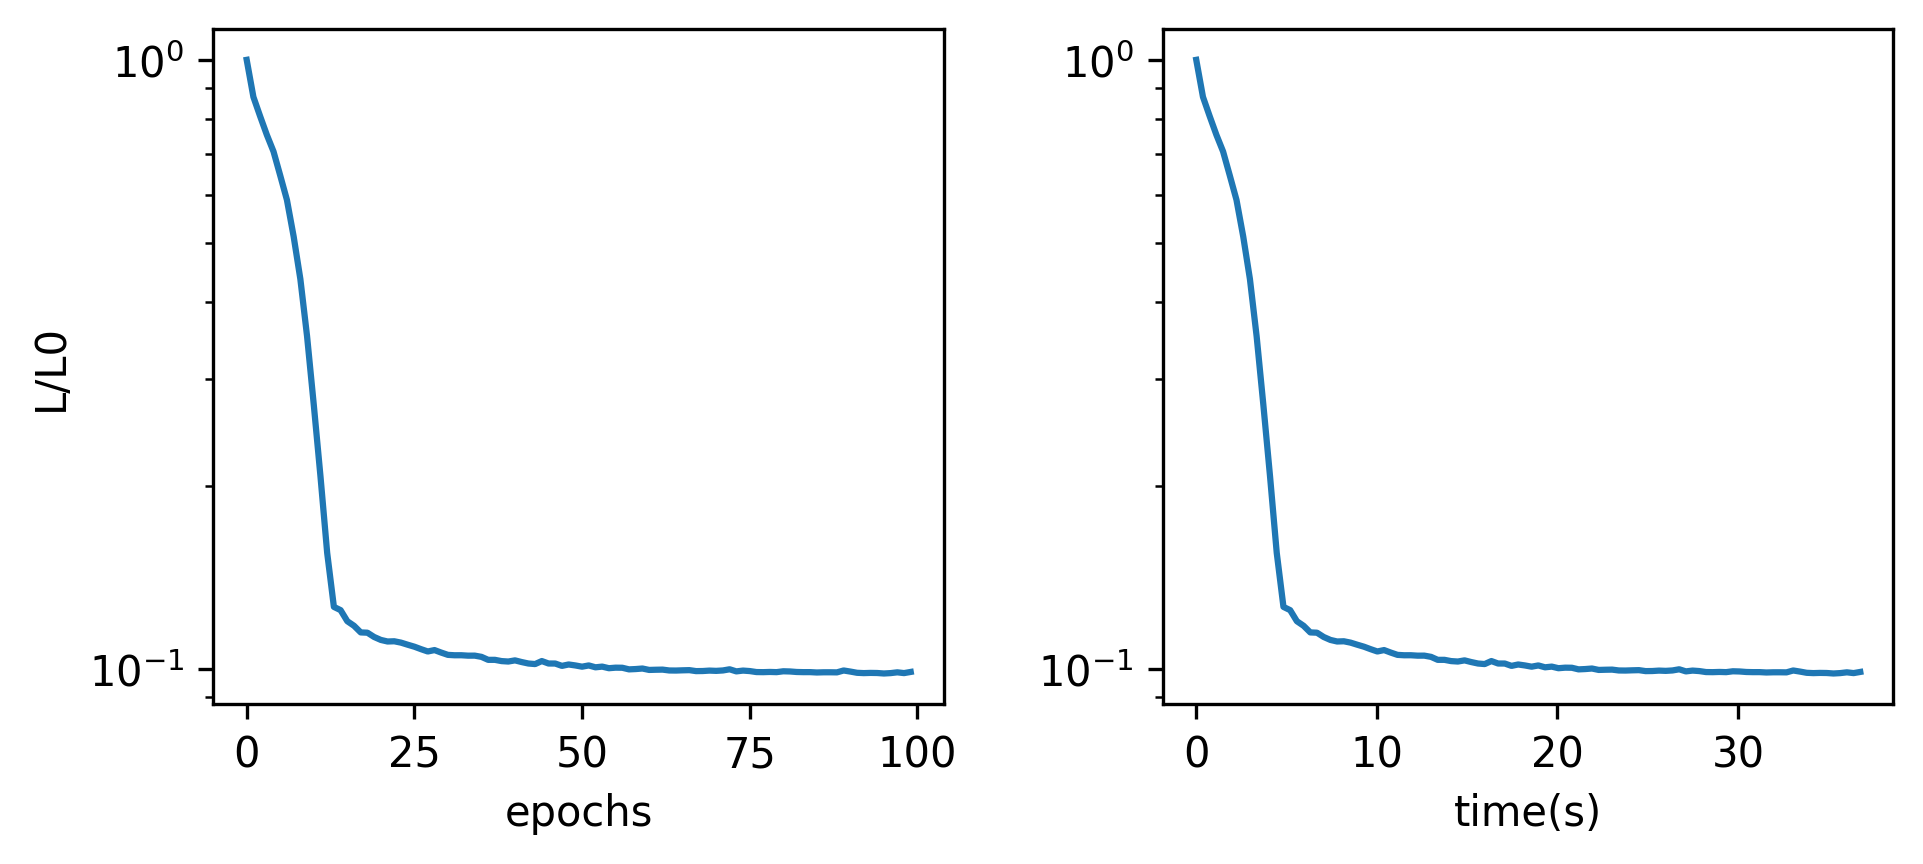

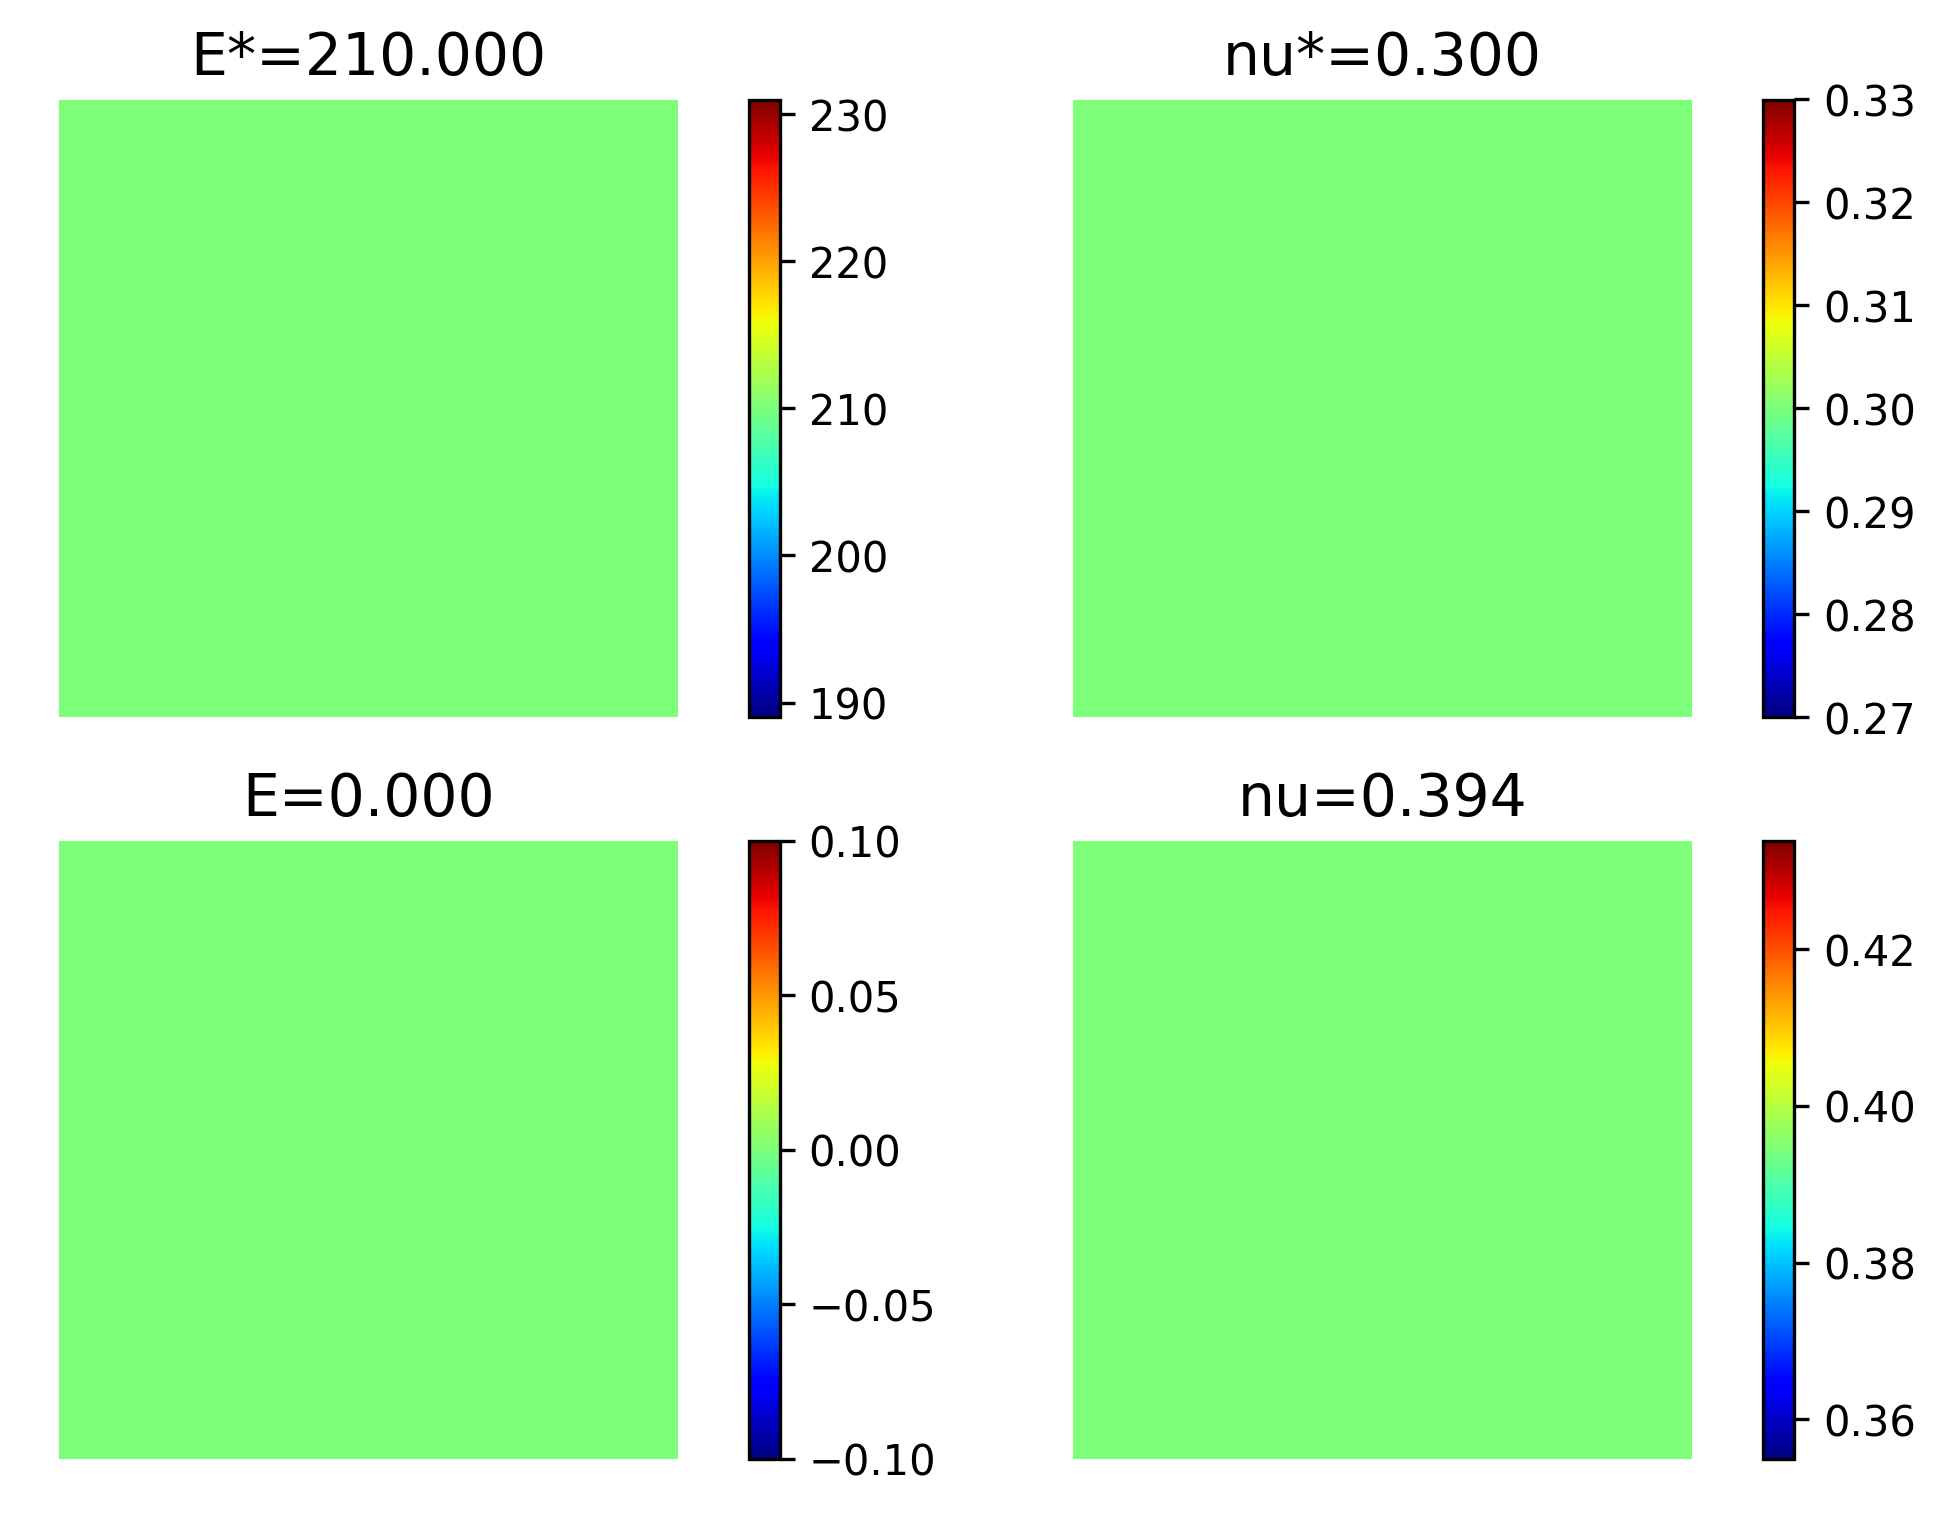

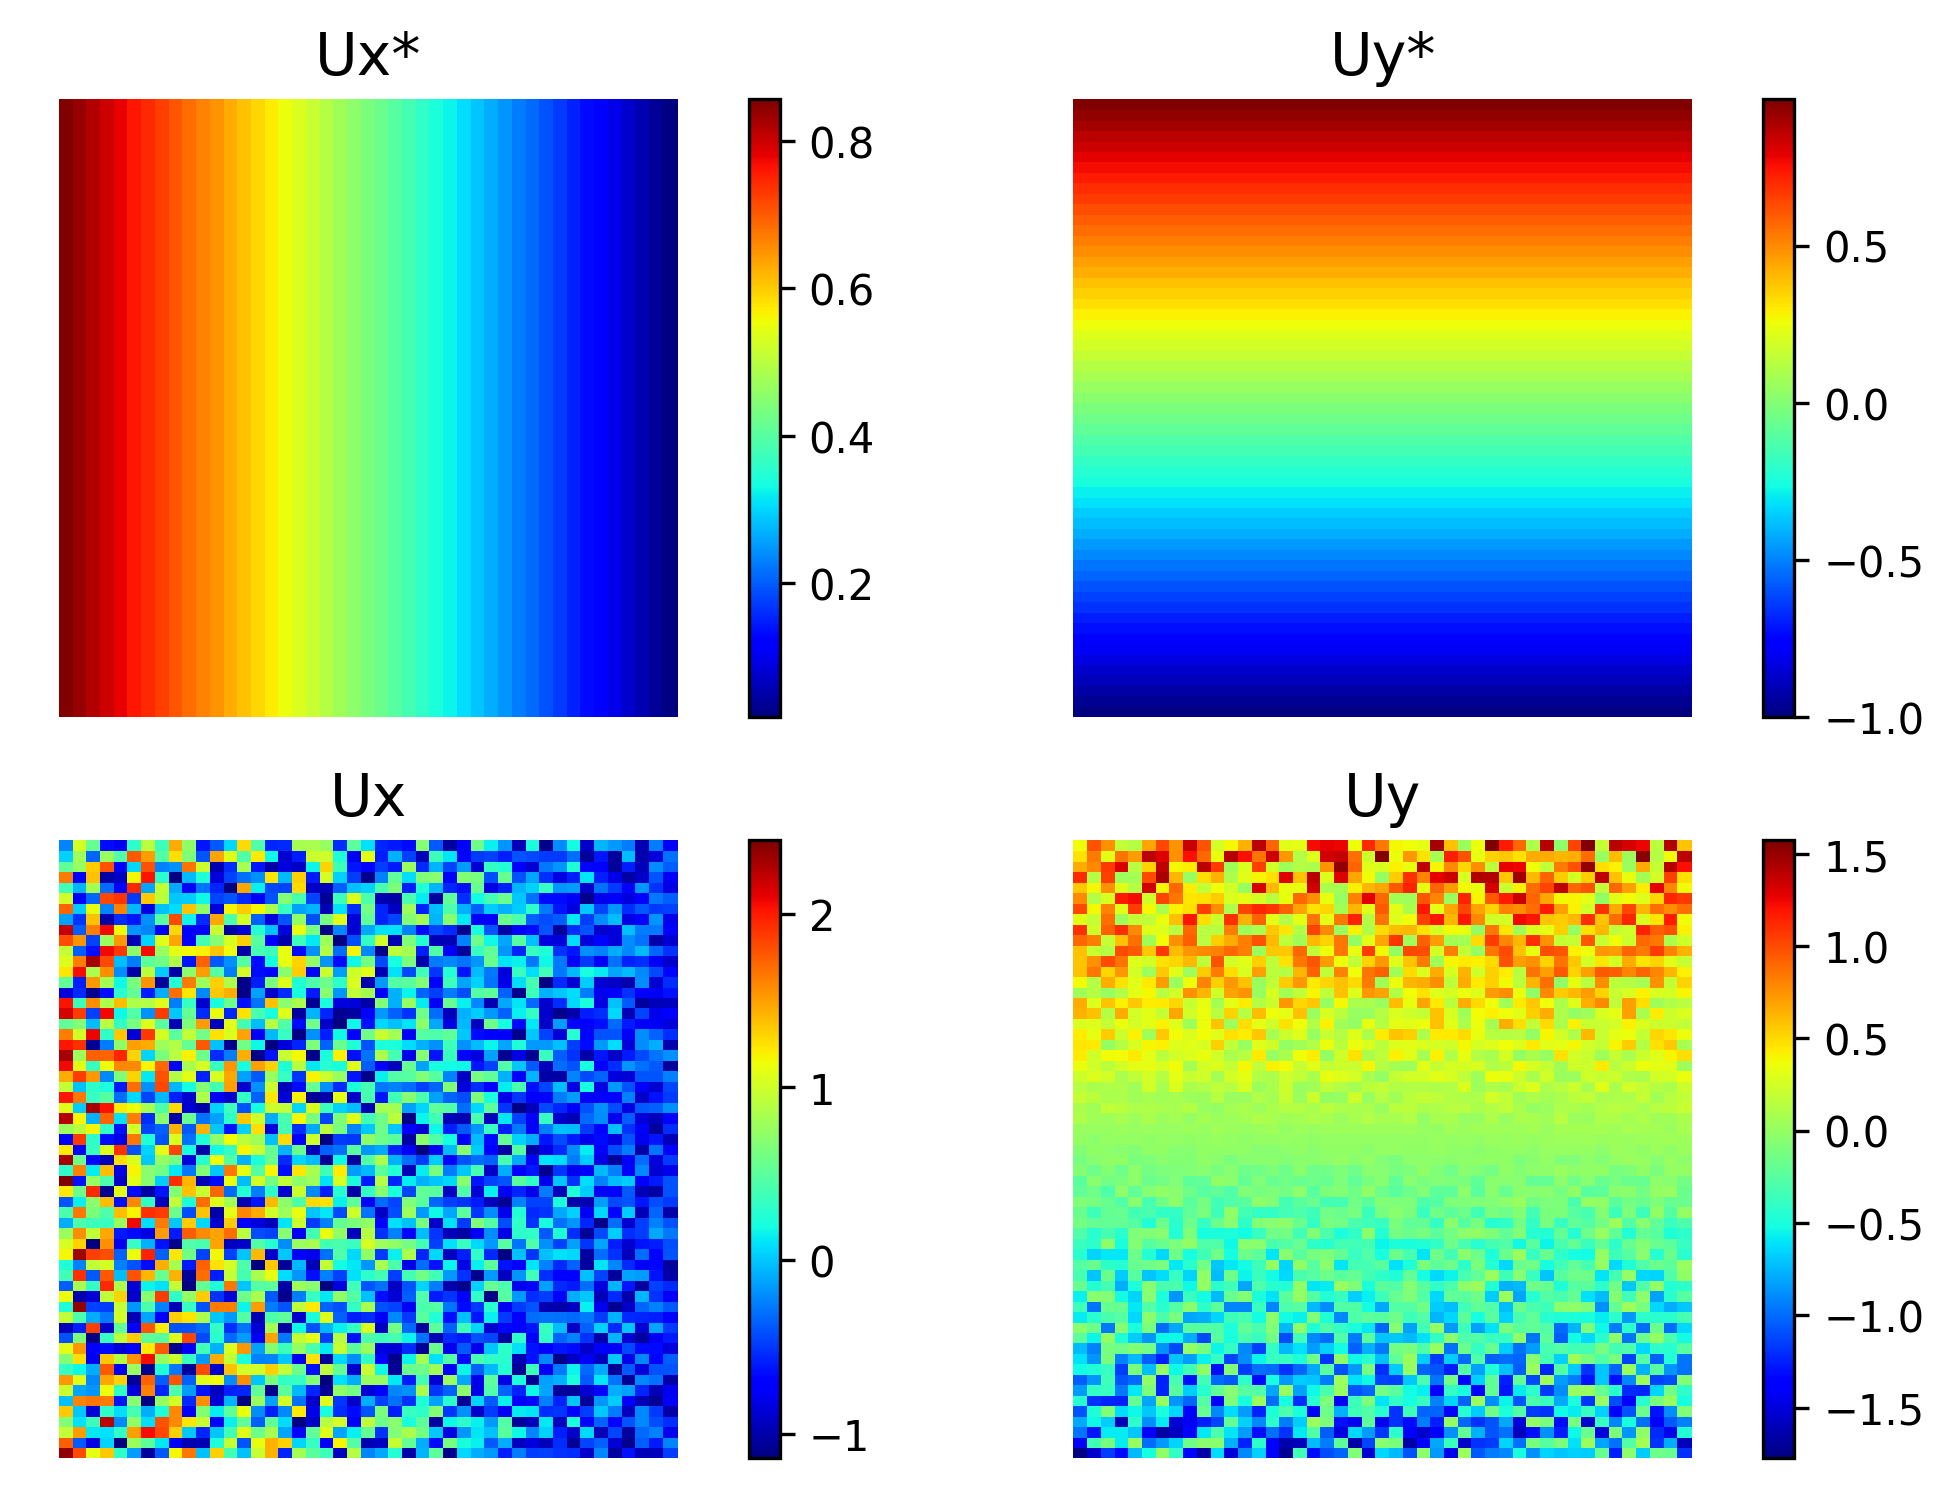

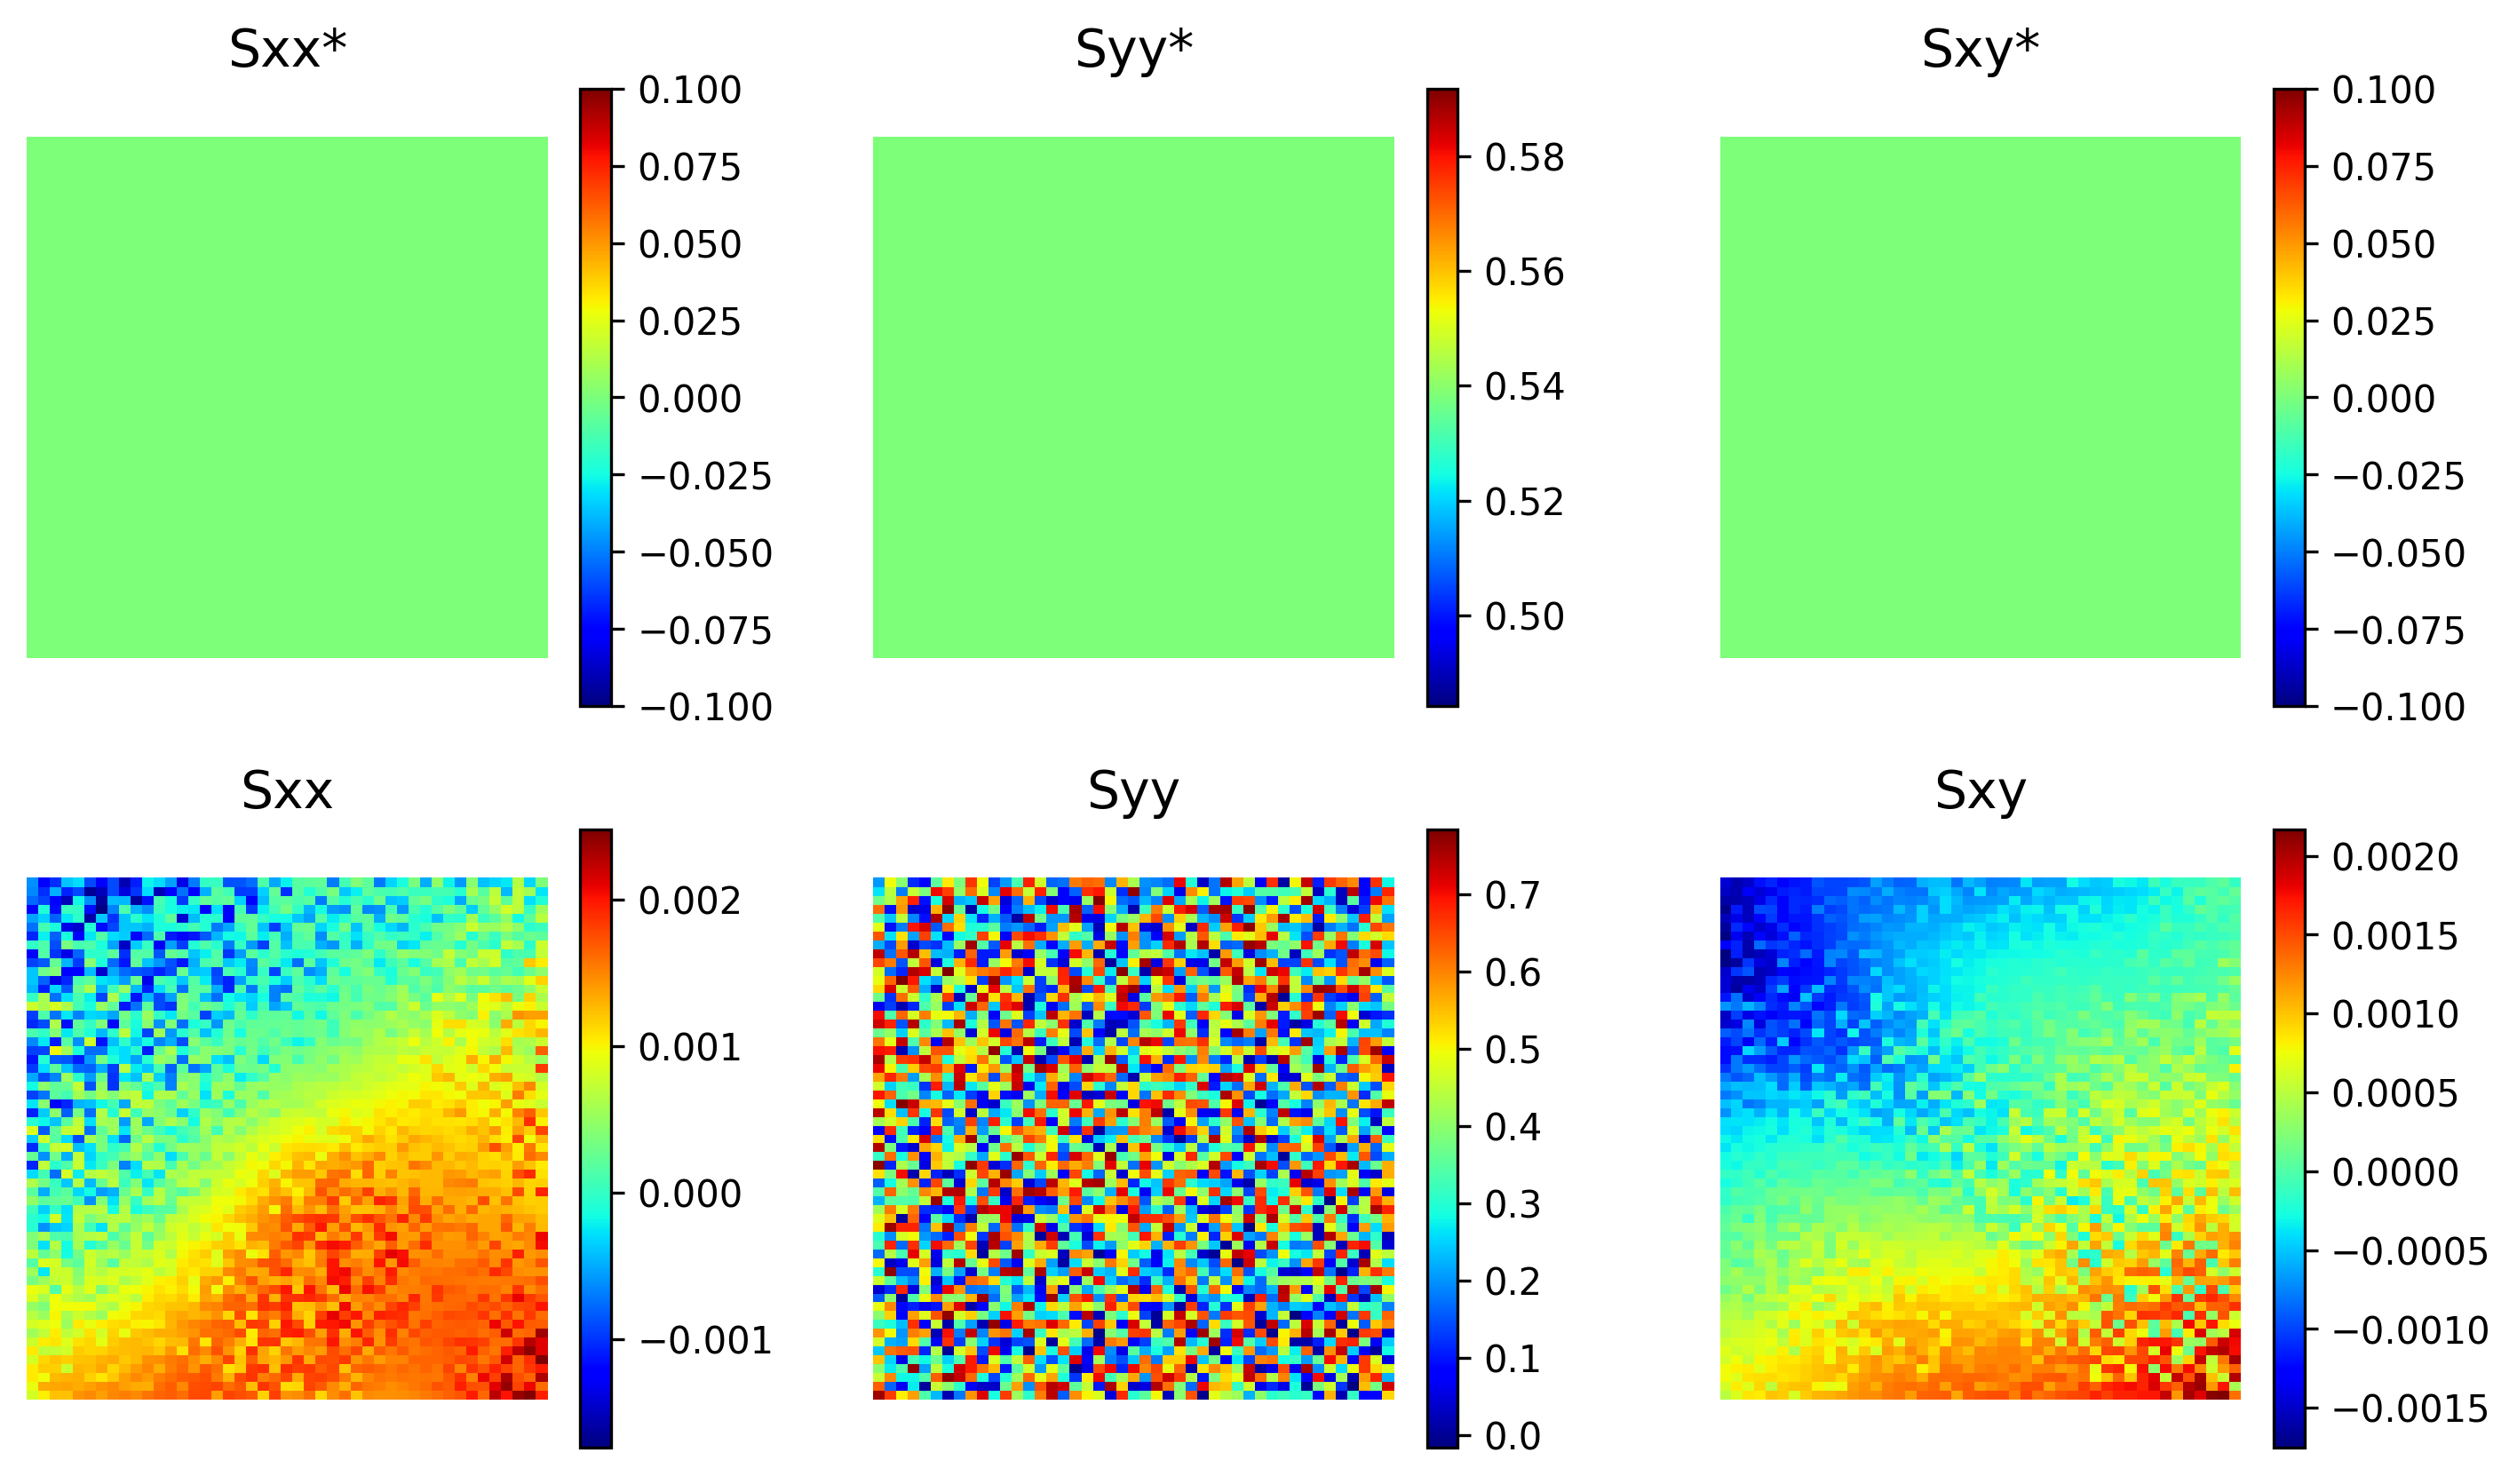

In [54]:
plot(Emod,nu)

In [ ]:
# Plot "exact" pressure field
#plt.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
#                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
#                  origin='lower', aspect='auto')

plt.imshow(P_exact, cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
plt.colorbar()

In [ ]:
set_in.step_080.sel(field='S22')